In [ ]:
from utils.binaries import *
from utils.plotting import *
from utils.Auger.SD import Monit
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from utils import CONSTANTS
import os

def parabola(x, scale, mip, y0):
    return scale * (x-mip)**2 + y0

def make_histo_fit(counts, p, mode, t=None, version=None):
     
    os.makedirs(f"/cr/data01/filip/plots/DaqIntegrationTest/{version}/pmt{int(p)}/", exist_ok=True)
    
    # see Framework/SDetector/Station.h
    match p:
        case 0 | 1 | 2:
            ADC = CONSTANTS.UUB_WCD_PEAK if mode == 'peak' else CONSTANTS.UUB_WCD_CHARGE
        case 3:
            ADC = CONSTANTS.UUB_SSD_PEAK if mode == 'peak' else CONSTANTS.UUB_SSD_CHARGE
    
    bin_change = 100 - 1 if mode == 'peak' else 400 - 1
    try:
        __peak = argrelextrema(counts[:bin_change], np.greater, order=bin_change)[0][0]
        x1, x2, y1, y2 = __peak, bin_change, counts[__peak], counts[bin_change]

        slope, offset = -(np.log(y1)-np.log(y2))/(x2-x1), np.log(y1)
        exp_fit = lambda x: np.exp(slope*(x-x1)+offset)

        guess = np.argmax(counts[__peak:bin_change] - exp_fit(range(__peak, bin_change)))
        start, stop = guess - 6, guess + 25
    
        (curve, mip, height), pcov = curve_fit(parabola, ADC[start:stop], counts[start:stop] - exp_fit(range(start, stop)),
                                        bounds=([-np.inf, 0, 0],[0, np.inf, np.inf]),
                                        maxfev=10000,
                                        p0=[-1, guess, counts[guess]])

        file_loc = f"/cr/data01/filip/plots/DaqIntegrationTest/{version}/pmt{int(p)}/{int(t)}-{mode}.png"
        if not os.path.isfile(file_loc):
            fig = plt.figure()
            plt.plot(ADC, counts)
            plt.axvline(ADC[start], c='k', lw=0.3, ls='--')
            plt.axvline(ADC[stop], c='k', lw=0.3, ls='--')
            plt.plot(ADC[start:stop], exp_fit(range(start, stop)), c='k', ls='--', lw=0.5)
            plt.plot(ADC[start:stop], parabola(ADC[start:stop], curve, mip, height) + exp_fit(range(start, stop)))
            plot.save(fig, f'DaqIntegrationTest/{version}/pmt{int(p)}/{int(t)}-{mode}.png')
            plt.close(fig)

        (_, mip, _) = uncertainties.correlated_values([curve, mip, height], pcov)
        if mip.std_dev / mip.n > 0.1: raise ValueError

        # if mip.n > 300 and mode=='peak': raise ValueError

        return mip.n, mip.std_dev
        
    except Exception as e:

        if not os.path.isfile(f"DaqIntegrationTest/{version}/pmt{int(p)}/failed-{int(t)}-{mode}.png"):
            fig = plt.figure()
            plt.plot(ADC, counts)
            plot.save(fig, f"DaqIntegrationTest/{version}/pmt{int(p)}/failed-{int(t)}-{mode}.png")
            plt.close(fig)

        return np.nan, np.nan

18:14:47 (   +6.6s) [INFO   ] -- received 3 file(s) as input
18:14:48 (  +578ms) [INFO   ] -- View monit keys with self.keys()
18:14:48 (    +7ms) [INFO   ] -- found 488 entries for key fTime and station #609
18:14:48 (   +12ms) [INFO   ] -- found 488 entries for key fPeak and station #609


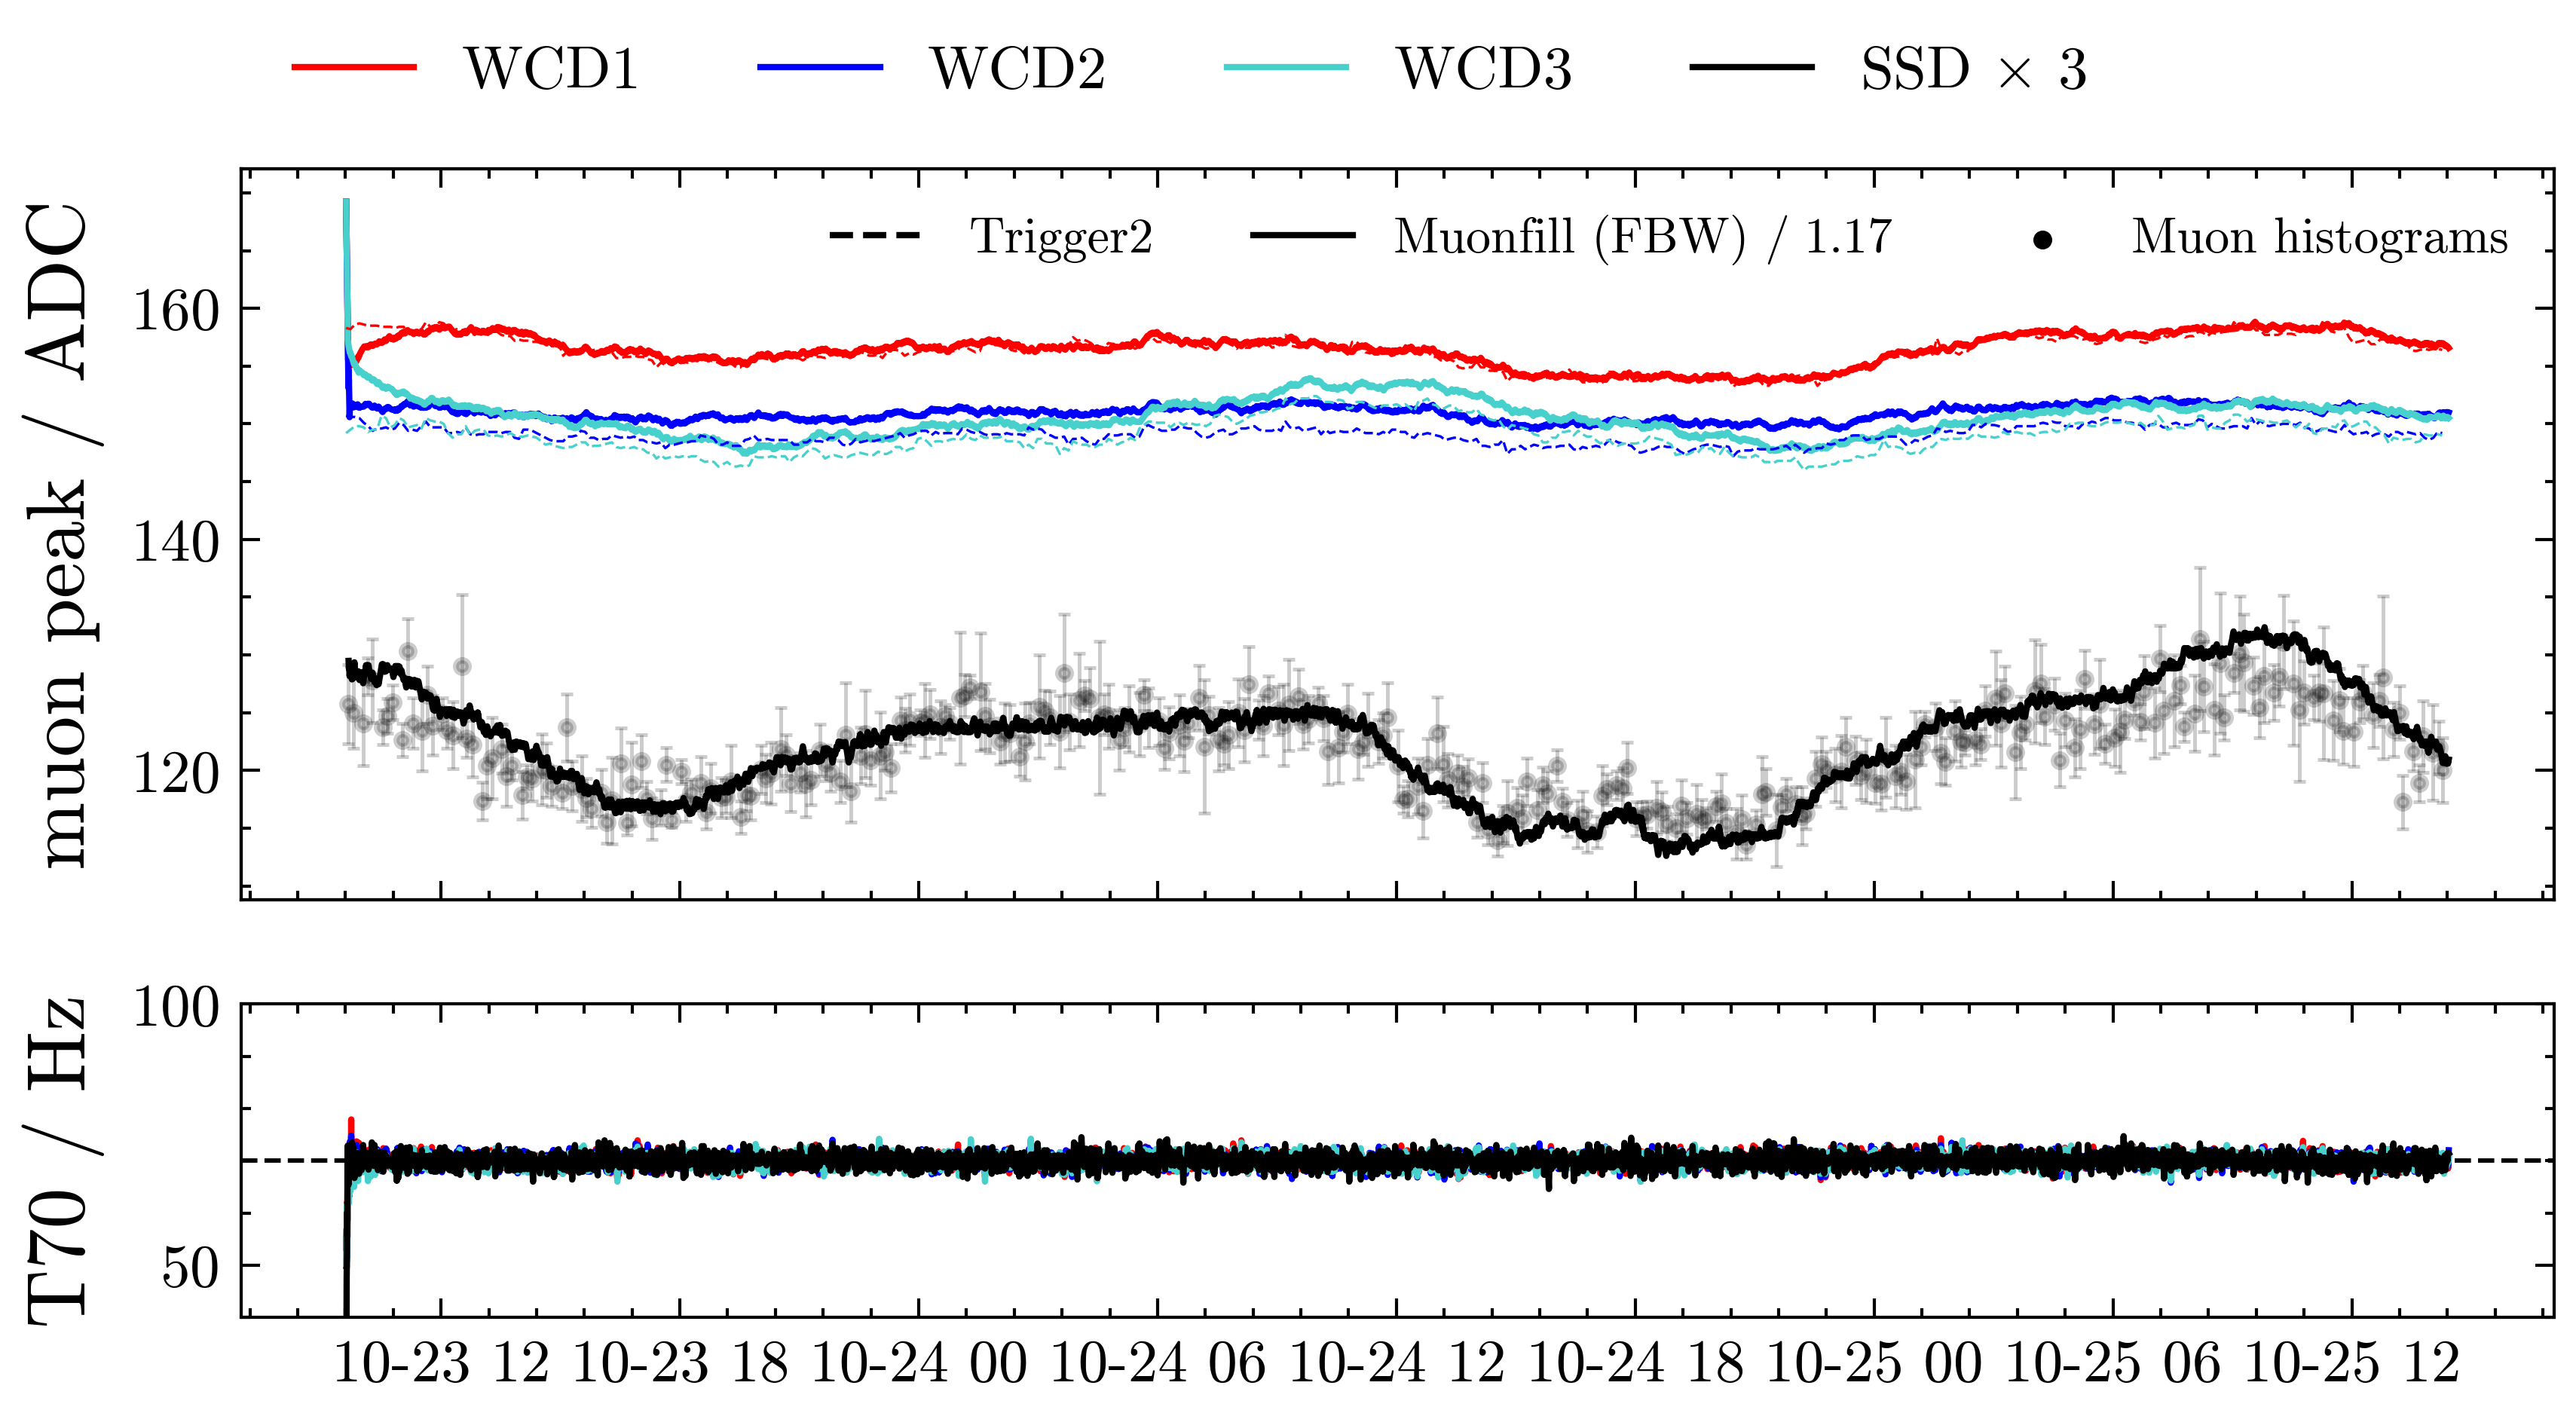

In [27]:
# try:
#     shutil.rmtree('/cr/data01/filip/plots/daqIntegrationTest/v36', )
# except: pass

from utils.binaries import *
from utils.plotting import *
from utils import CONSTANTS

from utils.Auger.SD import SdHisto
from utils.Auger.SD import Monit
import os

errorbar_kwargs = [
    {'marker' : 'x', 'c' : 'r'},
    {'marker' : '^', 'c' : 'b'},
    {'marker' : '*', 'c' : 'mediumturquoise'},
    {'marker' : 'o', 'c' : 'k'},
]

rerun_fits = False
FBW = 1.17**2 # to convert from FDS to FBW
f = 3

version = 'v43'
base = f'/cr/data01/filip/Data/daqIntegrationTests/{version}/'
monit_files = [base + file for file in os.listdir(base) if 'mc' in file]

monit = Monit(*monit_files)
t, wcds = monit('fTime', 609 if version >= 'v36' else 136), monit('fPeak', 609 if version >= 'v36' else 136).T
sort_indices = np.argsort(t)
t, (wcd1, wcd2, wcd3) = t[sort_indices], [w[sort_indices] for w in wcds]
trigger2_inactive_mask = [v!=0 for v in wcd3]

_, t_acq, t_gps, pmt, *phistos = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/peak.txt', unpack=True)
_,     _,     _,   _, *chistos = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/charge.txt', unpack=True)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[0.7, 0.3])

try:
    t_muonbuffer, mf_wcd1, hz1, mf_wcd2, hz2, mf_wcd3, hz3, ssd, hz4 = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/calib.test', unpack=True)
    t_muonbuffer += CONSTANTS.GPS_OFFSET

    ax1.plot(plot.to_datetime(t_muonbuffer), mf_wcd1 * 1/FBW, c='r', ls='-', label='WCD1')
    ax1.plot(plot.to_datetime(t_muonbuffer), mf_wcd2 * 1/FBW, c='blue', ls='-', label='WCD2')
    ax1.plot(plot.to_datetime(t_muonbuffer), mf_wcd3 * 1/FBW, c='mediumturquoise', ls='-', label='WCD3')
    ax1.plot(plot.to_datetime(t_muonbuffer[20:]), ssd[20:] * f * FBW, c='k')

    ax2.plot(plot.to_datetime(t_muonbuffer), hz1, c='r', ls='solid')
    ax2.plot(plot.to_datetime(t_muonbuffer), hz2, c='blue', ls='solid')
    ax2.plot(plot.to_datetime(t_muonbuffer), hz3, c='mediumturquoise', ls='solid')
    ax2.plot(plot.to_datetime(t_muonbuffer), hz4, c='k')   
except Exception as e:
    raise e

ax1.plot(plot.to_datetime(t[trigger2_inactive_mask]), wcd1[trigger2_inactive_mask], c='r', ls='--', lw=0.4)
ax1.plot(plot.to_datetime(t[trigger2_inactive_mask]), wcd2[trigger2_inactive_mask], c='b', ls='--', lw=0.4)
ax1.plot(plot.to_datetime(t[trigger2_inactive_mask]), wcd3[trigger2_inactive_mask], c='mediumturquoise', ls='--', lw=0.4)
ax1.plot([],[],c='k', ls='solid', label=rf'SSD $\times$ {f}')


phistos = np.split(np.array(phistos).T, len(phistos[0])/4)
chistos = np.split(np.array(chistos).T, len(chistos[0])/4)
t_gps = np.split(t_gps, len(t_gps)/4)


c = ['r', 'b', 'mediumturquoise', 'k']

if not os.path.isfile(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/ssd_fits.txt'):
    t_ssd, mip_ssd, mip_err = [], [], []
    for i, (tx, chisto, phisto) in enumerate(zip(t_gps, chistos, phistos)):
        histo = SdHisto(peak=phisto, charge=chisto)
        peaks = histo.fit()['peak']

        if not os.path.isfile(f'/cr/data01/filip/plots/DaqIntegrationTest/{version}/{int(tx[0])}.png') and not i%5:
            fig = histo.plot()
            plt.savefig(f'/cr/data01/filip/plots/DaqIntegrationTest/{version}/{int(tx[0])}.png')
            fig.clear()
            plt.close(fig)

        t_ssd.append(tx[3])
        mip_ssd.append(peaks[3][1].n)
        mip_err.append(peaks[3][1].std_dev)

    ssd_data = np.vstack([t_ssd, mip_ssd, mip_err])
    np.savetxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/ssd_fits.txt', ssd_data.T)
else:
    t_ssd, mip_ssd, mip_err = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/ssd_fits.txt', unpack=True)

ax1.errorbar(plot.to_datetime(t_ssd), mip_ssd * f, mip_err * f * FBW, ms=2, elinewidth=0.6, fmt='ko', capthick=0.6, capsize=1, alpha=0.2)

ax1_twin = ax1.twinx()
ax1_twin.plot([],[], c='k', ls='--', label=rf'Trigger2')
ax1_twin.plot([],[], c='k', ls='solid', label=rf'Muonfill (FBW) $/\ 1.17$')#\,{FBW}$')
ax1_twin.scatter([], [], marker='o', c='k', label='Muon histograms')
ax1_twin.legend(fontsize='small', ncols=3)
ax1_twin.set_ylim(*ax1.get_ylim())
ax1_twin.set_yticklabels([])

ax2.axhline(70, ls='--', c='k', lw=0.7)
ax2.set_ylim(40, 100)
ax1.set_ylabel("muon peak / ADC")
ax2.set_ylabel("T70 / Hz")
ax1.legend(bbox_to_anchor=(0, 1.02,1,0.2), loc="lower left", ncol=4)
ymin, ymax = ax1.get_ylim()
# ax1.set_ylim(ymin, 1.1 * ymax)

In [ ]:
data = np.vstack([t_ssd, mip_ssd, mip_err])
np.savetxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/ssd_fits.txt', data.T)

08:30:15 (   +8.6s) [INFO   ] -- received 3 file(s) as input
08:30:15 (  +348ms) [INFO   ] -- View monit keys with self.keys()
08:30:15 (    +7ms) [INFO   ] -- found 488 entries for key fTime and station #609
08:30:15 (   +14ms) [INFO   ] -- found 488 entries for key fPeak and station #609


Text(1, 1, 'Preliminary')

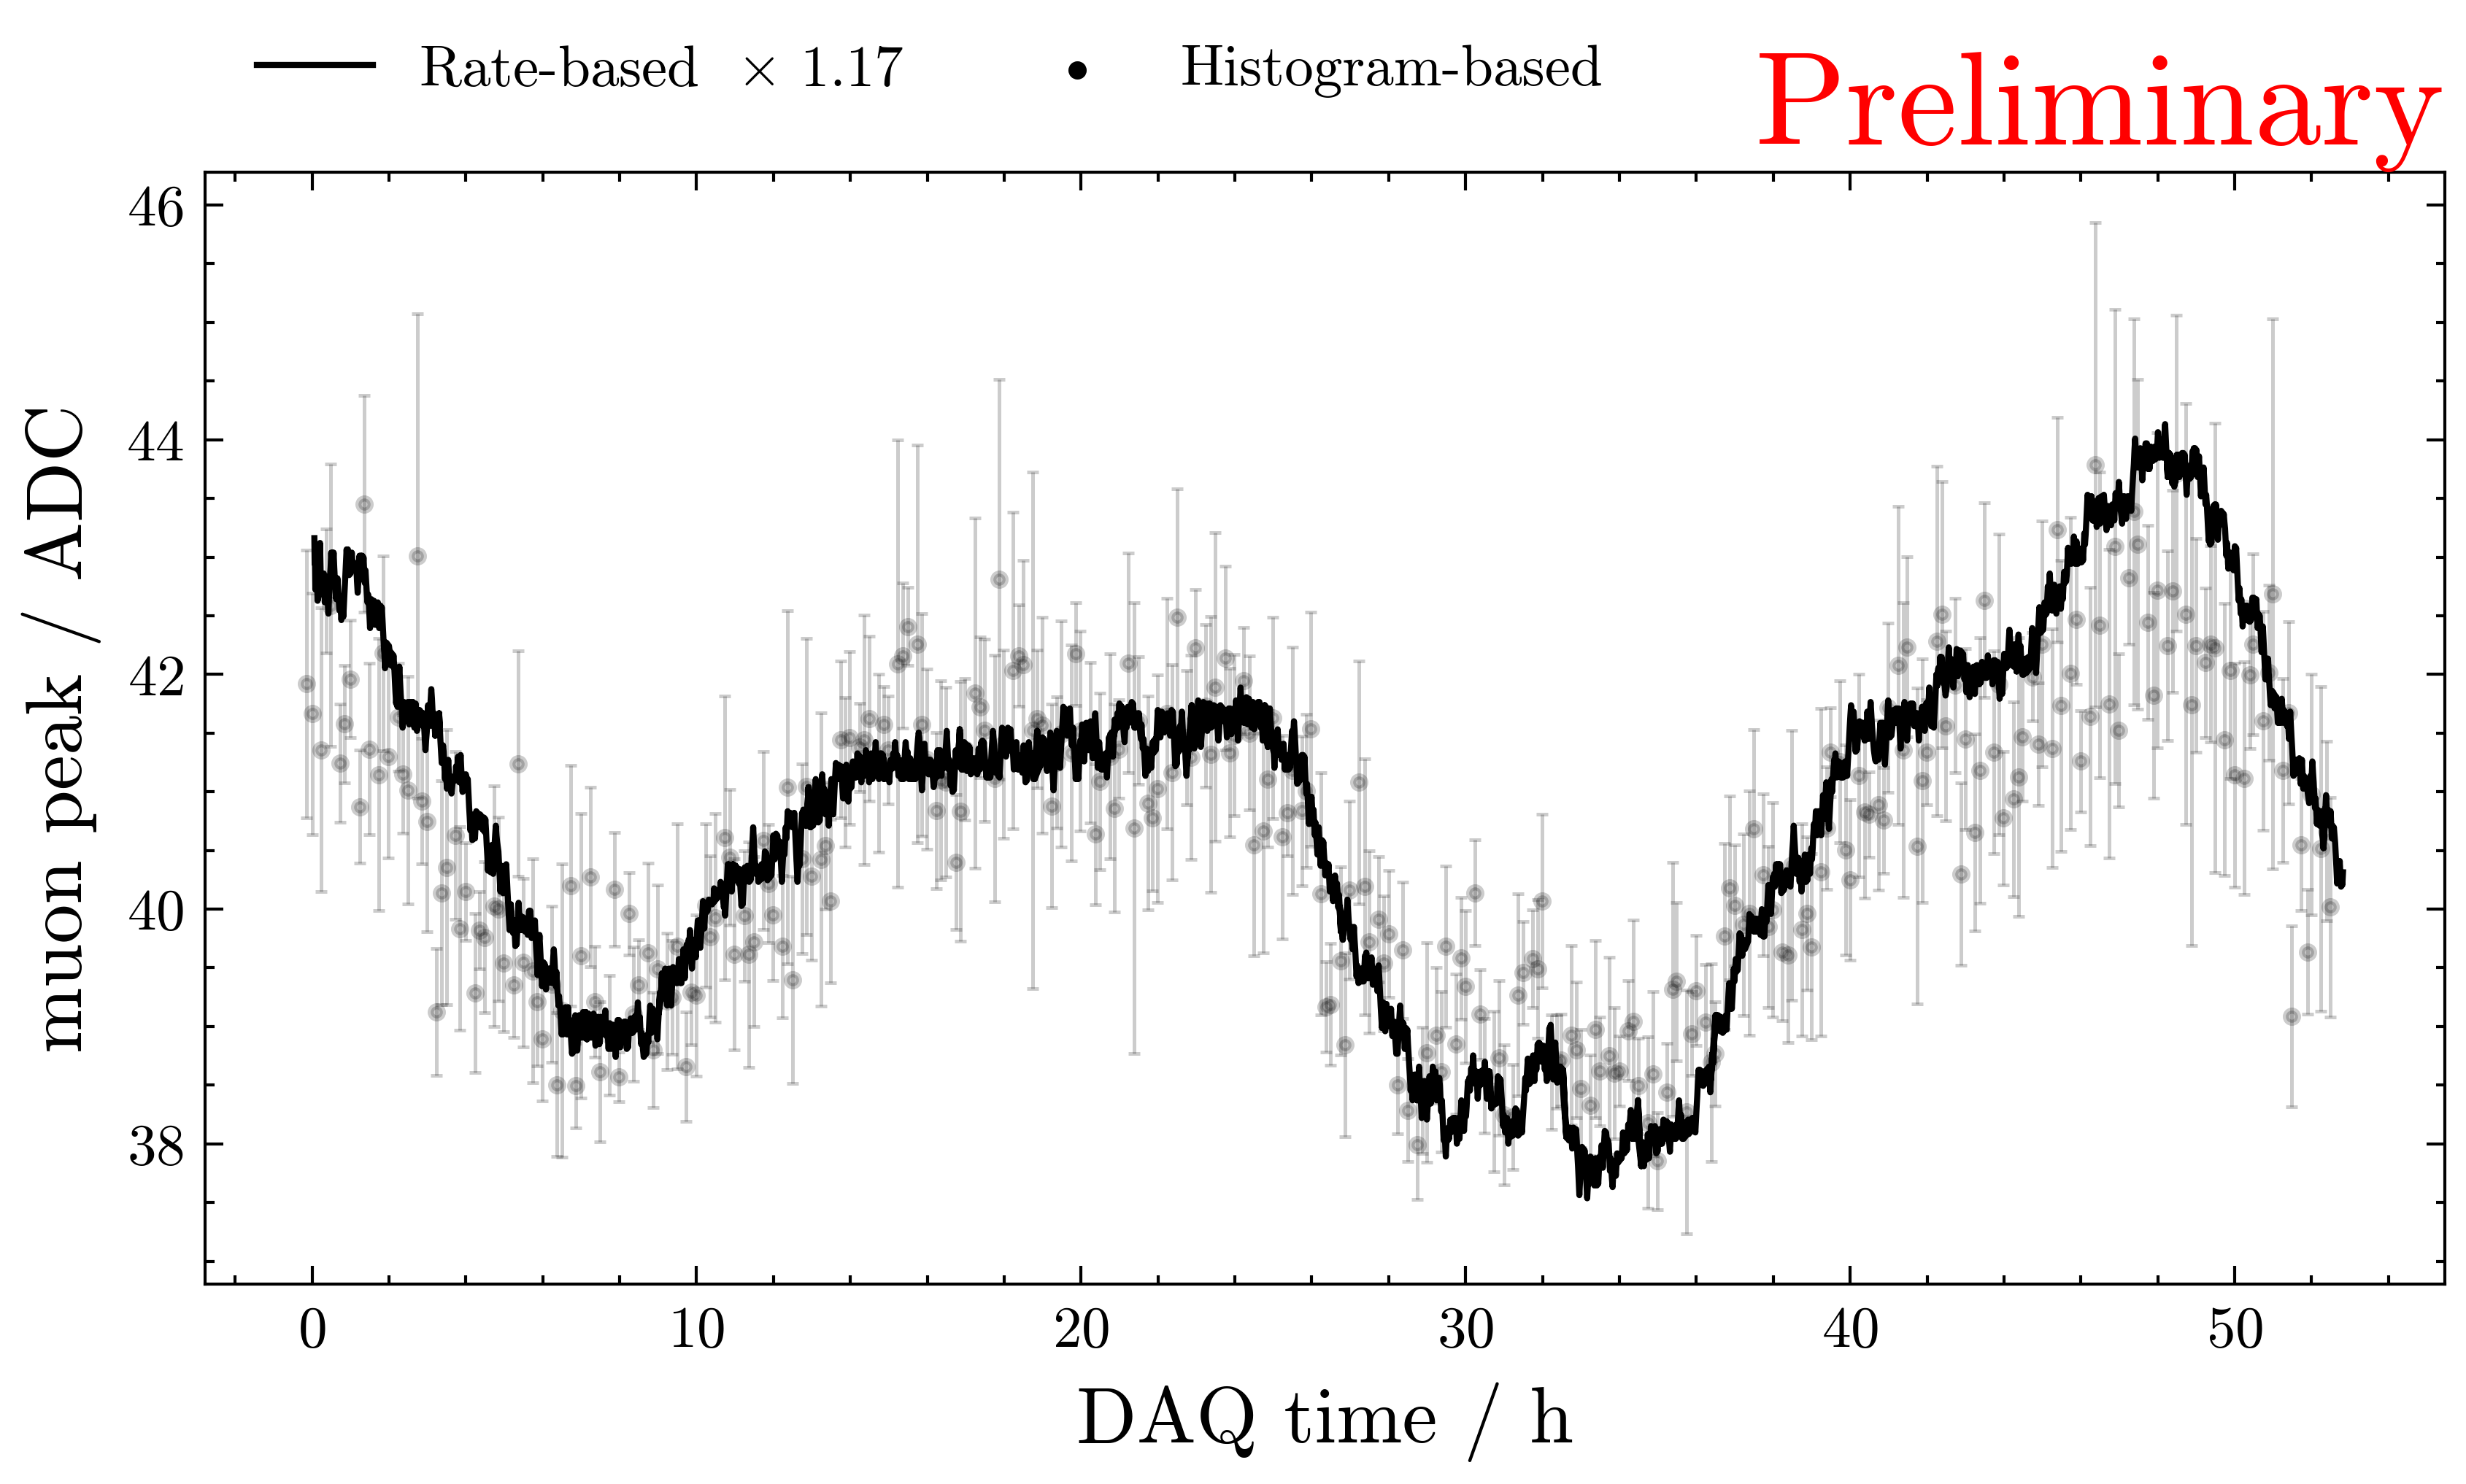

In [ ]:
# try:
#     shutil.rmtree('/cr/data01/filip/plots/daqIntegrationTest/v36', )
# except: pass

from utils.binaries import *
from utils.plotting import *
from utils import CONSTANTS

from utils.Auger.SD import SdHisto
from utils.Auger.SD import Monit
import os

errorbar_kwargs = [
    {'marker' : 'x', 'c' : 'r'},
    {'marker' : '^', 'c' : 'b'},
    {'marker' : '*', 'c' : 'mediumturquoise'},
    {'marker' : 'o', 'c' : 'k'},
]

rerun_fits = False
FBW = 1.17**2 # to convert from FDS to FBW
f = 1

version = 'v43'
base = f'/cr/data01/filip/Data/daqIntegrationTests/{version}/'
monit_files = [base + file for file in os.listdir(base) if 'mc' in file]

monit = Monit(*monit_files)
t, wcds = monit('fTime', 609 if version >= 'v36' else 136), monit('fPeak', 609 if version >= 'v36' else 136).T
sort_indices = np.argsort(t)
t, (wcd1, wcd2, wcd3) = t[sort_indices], [w[sort_indices] for w in wcds]
trigger2_inactive_mask = [v!=0 for v in wcd3]

_, t_acq, t_gps, pmt, *phistos = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/peak.txt', unpack=True)
_,     _,     _,   _, *chistos = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/charge.txt', unpack=True)
fig, ax1 = plt.subplots(1, 1, sharex=True, height_ratios=[1])

try:
    t_muonbuffer, mf_wcd1, hz1, mf_wcd2, hz2, mf_wcd3, hz3, ssd, hz4 = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/calib.test', unpack=True)
    t_muonbuffer += CONSTANTS.GPS_OFFSET

    # ax1.plot(plot.to_datetime(t_muonbuffer), mf_wcd1 * 1/FBW, c='r', ls='-', label='WCD1')
    # ax1.plot(plot.to_datetime(t_muonbuffer), mf_wcd2 * 1/FBW, c='blue', ls='-', label='WCD2')
    # ax1.plot(plot.to_datetime(t_muonbuffer), mf_wcd3 * 1/FBW, c='mediumturquoise', ls='-', label='WCD3')
    ax1.plot((t_muonbuffer[20:] - t_muonbuffer[0]) / 3600, ssd[20:] * f * FBW, c='k')

    # ax2.plot(plot.to_datetime(t_muonbuffer), hz1, c='r', ls='solid')
    # ax2.plot(plot.to_datetime(t_muonbuffer), hz2, c='blue', ls='solid')
    # ax2.plot(plot.to_datetime(t_muonbuffer), hz3, c='mediumturquoise', ls='solid')
    # ax2.plot((t_muonbuffer - t_muonbuffer[0]) / 3600, hz4, c='k')   
except Exception as e:
    raise e

# ax1.plot(plot.to_datetime(t[trigger2_inactive_mask]), wcd1[trigger2_inactive_mask], c='r', ls='--', lw=0.4)
# ax1.plot(plot.to_datetime(t[trigger2_inactive_mask]), wcd2[trigger2_inactive_mask], c='b', ls='--', lw=0.4)
# ax1.plot(plot.to_datetime(t[trigger2_inactive_mask]), wcd3[trigger2_inactive_mask], c='mediumturquoise', ls='--', lw=0.4)
# ax1.plot([],[],c='k', ls='solid', label=rf'SSD $\times$ {f}')


phistos = np.split(np.array(phistos).T, len(phistos[0])/4)
chistos = np.split(np.array(chistos).T, len(chistos[0])/4)
t_gps = np.split(t_gps, len(t_gps)/4)


c = ['r', 'b', 'mediumturquoise', 'k']

if not os.path.isfile(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/ssd_fits.txt'):
    t_ssd, mip_ssd, mip_err = [], [], []
    for i, (tx, chisto, phisto) in enumerate(zip(t_gps, chistos, phistos)):
        histo = SdHisto(peak=phisto, charge=chisto)
        peaks = histo.fit()['peak']

        if not os.path.isfile(f'/cr/data01/filip/plots/DaqIntegrationTest/{version}/{int(tx[0])}.png') and not i%5:
            fig = histo.plot()
            plt.savefig(f'/cr/data01/filip/plots/DaqIntegrationTest/{version}/{int(tx[0])}.png')
            fig.clear()
            plt.close(fig)

        t_ssd.append(tx[3])
        mip_ssd.append(peaks[3][1].n)
        mip_err.append(peaks[3][1].std_dev)

    ssd_data = np.vstack([t_ssd, mip_ssd, mip_err])
    np.savetxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/ssd_fits.txt', ssd_data.T)
else:
    t_ssd, mip_ssd, mip_err = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/ssd_fits.txt', unpack=True)

ax1.errorbar((t_ssd - t_ssd[0]) / 3600, mip_ssd * f, mip_err * f * FBW, ms=2, elinewidth=0.6, fmt='ko', capthick=0.6, capsize=1, alpha=0.2)

# ax1_twin = ax1.twinx()
ax1_twin = ax1
# ax1_twin.plot([],[], c='k', ls='--', label=rf'Trigger2')
ax1_twin.plot([],[], c='k', ls='solid', label=rf'Rate-based $\,\times\,1.17$')
ax1_twin.scatter([], [], marker='o', c='k', label='Histogram-based')
ax1_twin.legend(fontsize='small', ncols=3)
ax1_twin.set_ylim(*ax1.get_ylim())
# ax1_twin.set_yticklabels([])

# ax2.axhline(70, ls='--', c='k', lw=0.7)
# ax2.set_ylim(40, 100)
ax1.set_ylabel("MIP peak / ADC")
ax1.set_xlabel("DAQ time / h")
# ax2.set_ylabel("T70 / Hz")
ax1.legend(bbox_to_anchor=(0, 1.02,1,0.2), loc="lower left", ncol=4)
ymin, ymax = ax1.get_ylim()
# ax1.set_ylim(ymin, 1.1 * ymax)

ax1.text(1, 1, 'Preliminary', c='red', ha='right', va='bottom', fontsize=22,
    transform=ax1.transAxes
)